In [1]:
# Implementaciones
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Imagenes para usarla con Canny
imagenes1 = [ 
    "../Imagenes2/14.bmp",
    "../Imagenes2/20.bmp",
    "../Imagenes2/ab1.png"
]

In [4]:
def gaussian_blur(img, ksize=5, sigma=1.0):
    """Aplica filtro Gaussiano 2D manualmente."""
    ax = np.linspace(-(ksize // 2), ksize // 2, ksize)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel = kernel / np.sum(kernel)

    return cv2.filter2D(img, -1, kernel)

In [5]:
def sobel_filters(img):
    """Calcula gradiente en X e Y usando Sobel."""
    Kx = np.array([[ -1, 0, 1],
                   [ -2, 0, 2],
                   [ -1, 0, 1]])
    
    Ky = np.array([[ -1, -2, -1],
                   [  0,  0,  0],
                   [  1,  2,  1]])

    Ix = cv2.filter2D(img, cv2.CV_64F, Kx)
    Iy = cv2.filter2D(img, cv2.CV_64F, Ky)

    G = np.hypot(Ix, Iy)            # Magnitud
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)      # Dirección

    return G.astype(np.uint8), theta
    

In [23]:
def non_maximum_suppression(G, theta):
    M, N = G.shape
    Z = np.zeros((M,N), dtype=np.uint8)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180
    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

                # 0 grados
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = G[i, j+1]
                    r = G[i, j-1]
                # 45 grados
                elif (22.5 <= angle[i,j] < 67.5):
                    q = G[i+1, j-1]
                    r = G[i-1, j+1]
                # 90 grados
                elif (67.5 <= angle[i,j] < 112.5):
                    q = G[i+1, j]
                    r = G[i-1, j]
                # 135 grados
                elif (112.5 <= angle[i,j] < 157.5):
                    q = G[i-1, j-1]
                    r = G[i+1, j+1]

                if (G[i,j] >= q) and (G[i,j] >= r):
                    Z[i,j] = G[i,j]
                else:
                    Z[i,j] = 0

            except IndexError:
                pass
    return Z

In [24]:
def hysteresis(img, low_thresh, high_thresh):
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.uint8)
    
    strong = 255
    weak = 75

    strong_i, strong_j = np.where(img >= high_thresh)
    weak_i, weak_j = np.where((img >= low_thresh) & (img < high_thresh))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    for i in range(1, M-1):
        for j in range(1, N-1):
            if res[i,j] == weak:
                if ((res[i+1, j-1] == strong) or (res[i+1, j] == strong) or (res[i+1, j+1] == strong)
                    or (res[i, j-1] == strong) or (res[i, j+1] == strong)
                    or (res[i-1, j-1] == strong) or (res[i-1, j] == strong) or (res[i-1, j+1] == strong)):
                    res[i,j] = strong
                else:
                    res[i,j] = 0
    return res

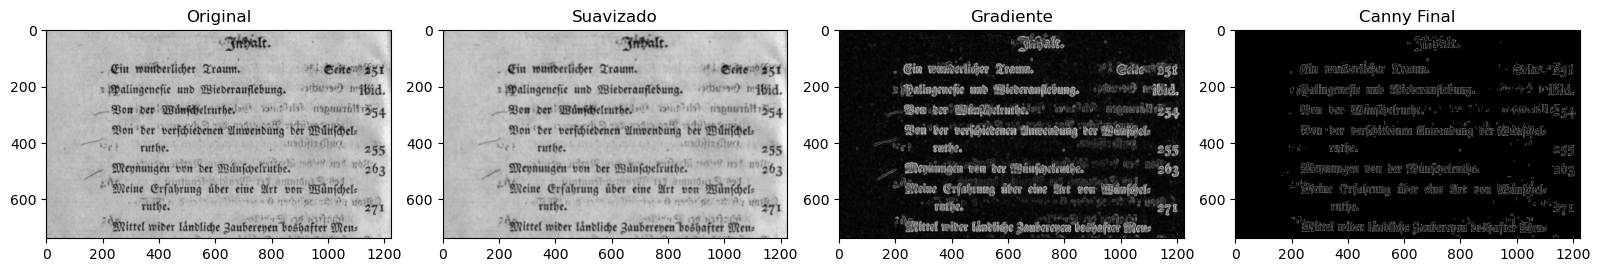

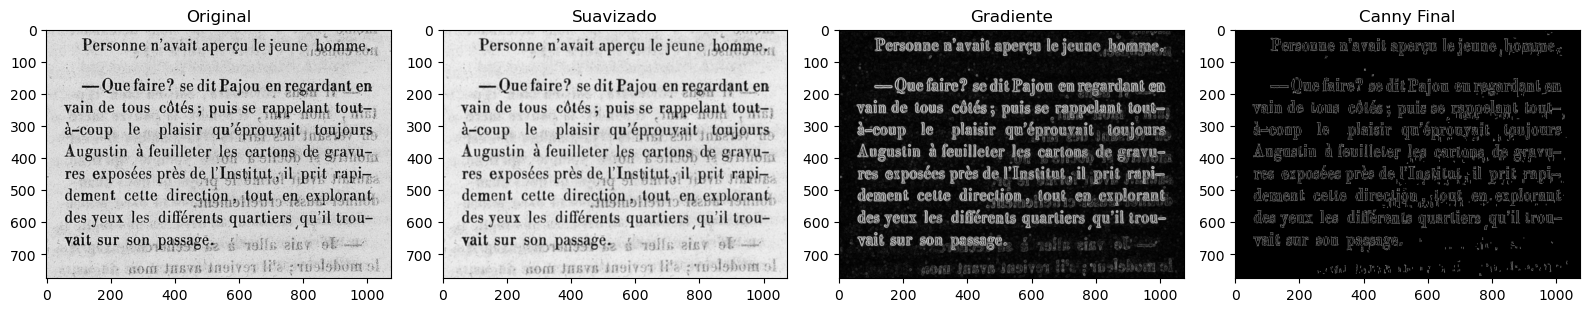

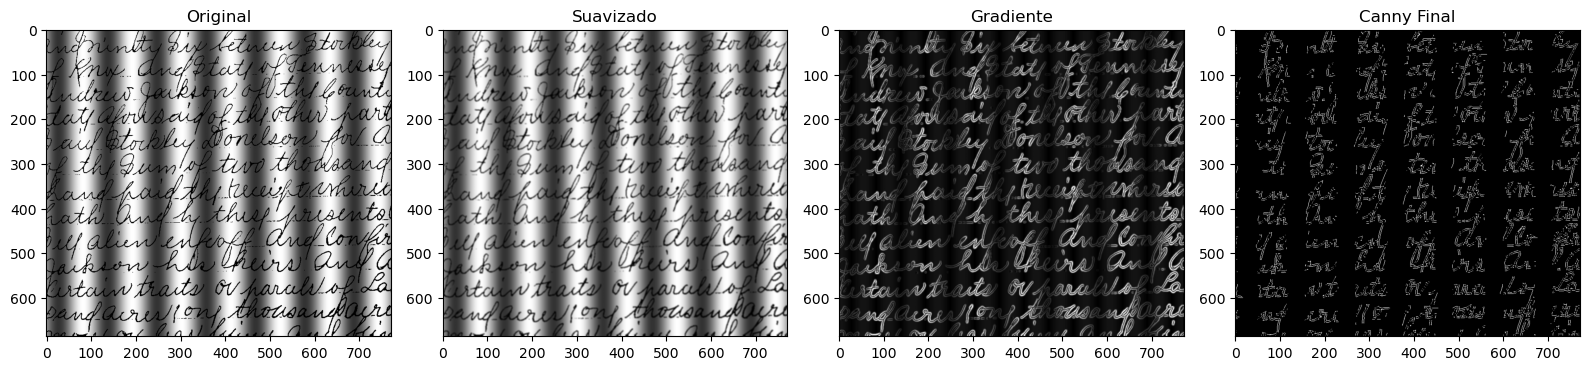

In [25]:
# OPERACION DEL CONJUNTO IMAGENES1 
for src_image in imagenes1:
    img = cv2.imread(src_image, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"[ERROR] No se pudo cargar la imagen: {src_image}")
        continue

    # Paso 1: Suavizado
    blurred = gaussian_blur(img, ksize=5, sigma=1.4)

    # Paso 2: Gradiente
    magnitude, direction = sobel_filters(blurred)

    # Paso 3: Supresión no-máxima
    nms = non_maximum_suppression(magnitude, direction)

    # Paso 4: Umbralado con histéresis
    final_edges = hysteresis(nms, low_thresh=50, high_thresh=100)

    # Mostrar resultados
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(img, cmap='gray')

    plt.subplot(1, 4, 2)
    plt.title("Suavizado")
    plt.imshow(blurred, cmap='gray')

    plt.subplot(1, 4, 3)
    plt.title("Gradiente")
    plt.imshow(magnitude, cmap='gray')

    plt.subplot(1, 4, 4)
    plt.title("Canny Final")
    plt.imshow(final_edges, cmap='gray')

    plt.tight_layout()
    plt.show()

In [7]:
for src_image in imagenes2:
    print(src_image)
    print(type(src_image))

../Imagenes2/Lab2.jpg
<class 'str'>
../Imagenes2/Lab03.jpg
<class 'str'>
../Imagenes2/Lab04.jpg
<class 'str'>
../Imagenes2/lab05.bmp
<class 'str'>


In [17]:
# Iamgenes para usarla con Otzu
imagenes2 = [
    "../Imagenes2/Lab2.jpg",
    "../Imagenes2/Lab03.jpg",
    "../Imagenes2/Lab04.jpg",
    "../Imagenes2/lab05.jpg"
]

In [18]:
def compute_histogram(img):
    """Calcula el histograma de una imagen en escala de grises."""
    hist = np.zeros(256)
    for pixel in img.ravel():
        hist[pixel] += 1
    return hist / img.size  # normalizado

In [19]:
def otsu_threshold(img):
    """Calcula el umbral óptimo usando el método de Otsu."""
    hist = compute_histogram(img)
    total = img.size

    max_var = 0
    best_thresh = 0

    # Variables acumulativas
    sum_total = np.dot(np.arange(256), hist)
    sumB = 0
    weightB = 0
    weightF = 0

    for t in range(256):
        weightB += hist[t]
        if weightB == 0:
            continue
        weightF = 1 - weightB
        if weightF == 0:
            break

        sumB += t * hist[t]

        meanB = sumB / weightB
        meanF = (sum_total - sumB) / weightF

        # varianza entre clases
        between_var = weightB * weightF * (meanB - meanF)**2

        if between_var > max_var:
            max_var = between_var
            best_thresh = t

    return best_thresh

In [20]:
def apply_threshold(img, threshold):
    """Aplica un umbral dado a la imagen."""
    binary = np.where(img > threshold, 255, 0).astype(np.uint8)
    return binary

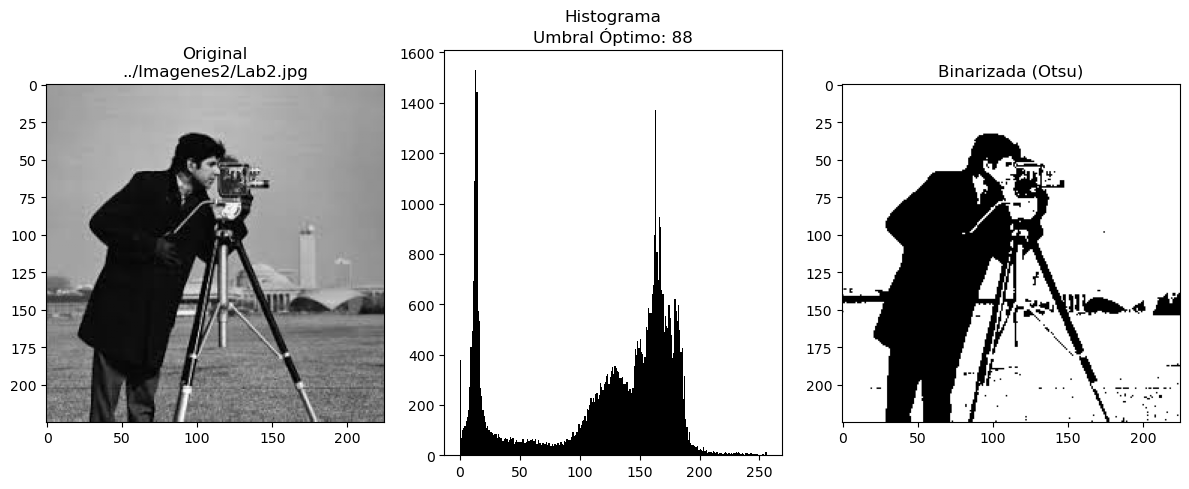

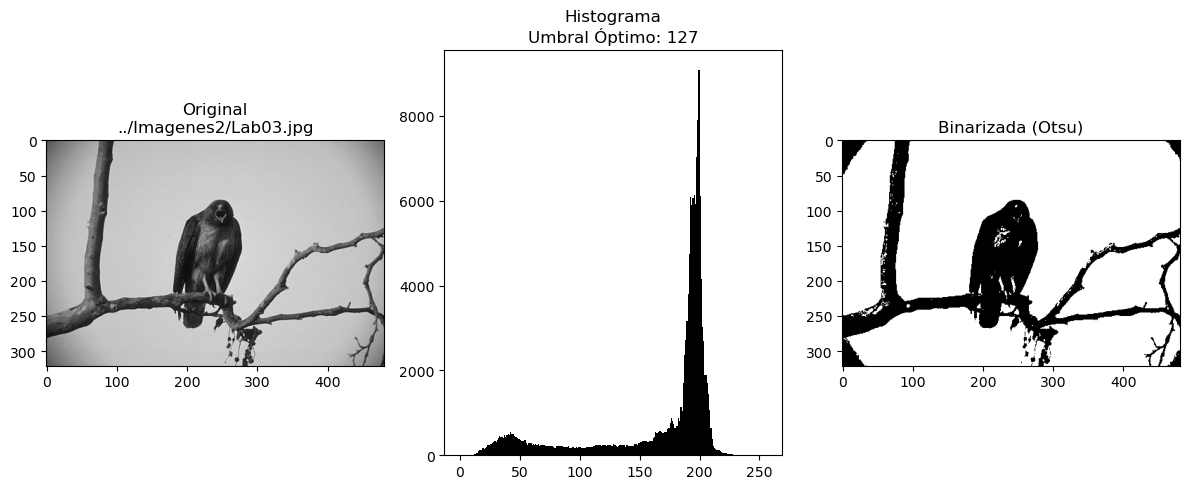

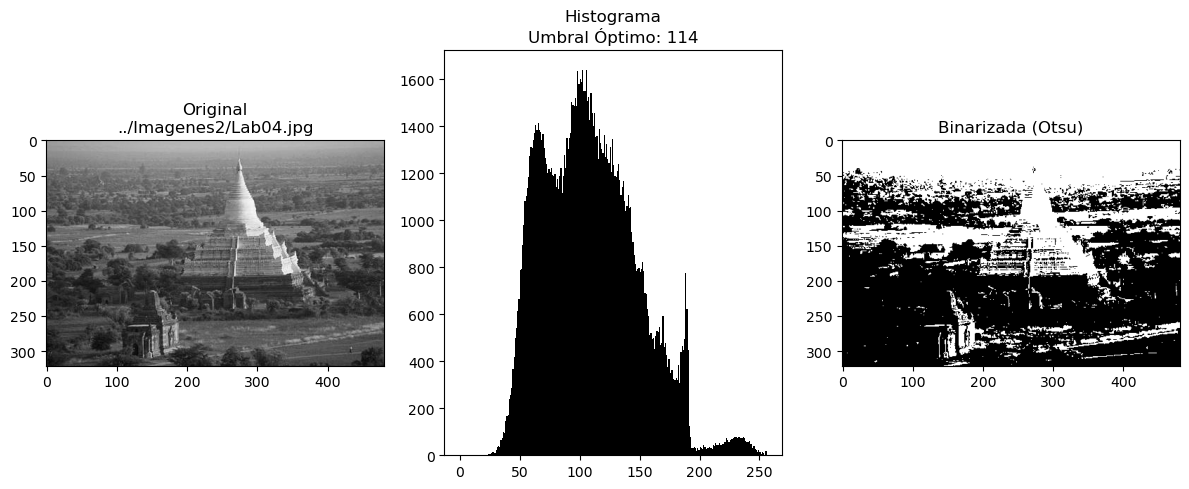

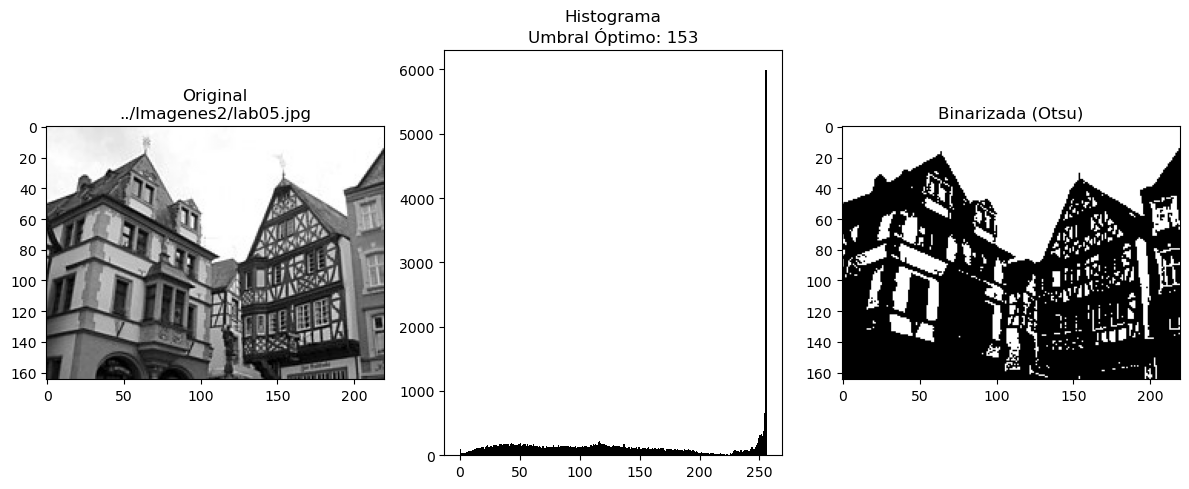

In [21]:
# OPERACION DEL CONJUNTO IMAGENES2
for src_image in imagenes2: 
    img = cv2.imread(src_image, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"[ERROR] No se pudo cargar la imagen: {src_image}")
        continue  # pasa a la siguiente imagen

    # Calcular umbral óptimo
    threshold = otsu_threshold(img)
    binary_img = apply_threshold(img, threshold)

    # Mostrar resultados
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.title(f"Original\n{src_image}")
    plt.imshow(img, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title(f"Histograma\nUmbral Óptimo: {threshold}")
    plt.hist(img.ravel(), bins=256, range=(0, 256), color='black')

    plt.subplot(1, 3, 3)
    plt.title("Binarizada (Otsu)")
    plt.imshow(binary_img, cmap='gray')

    plt.tight_layout()
    plt.show()